In [2]:
import torch
import coremltools as ct
from colorization.colorizers import eccv16

### Loads the `eccv16` model

In [2]:
eccv16_model = eccv16(pretrained=True).eval()

### Traces the model and converts to `.mlpackage`

In [3]:
example_input = torch.rand(1, 1, 512, 512)
traced_model = torch.jit.trace(eccv16_model, example_input) 

In [4]:
coreml_model = ct.convert(
    traced_model,
    inputs=[ct.TensorType(name="input1", shape=(1, 1, 512, 512))]
)
coreml_model.save("ECCV16Colorize.mlpackage")

When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_target' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://apple.github.io/coremltools/docs-guides/source/target-conversion-formats.html
Running MIL default pipeline:   0%|          | 0/78 [00:00<?, ? passes/s]/Users/captain-mac/Documents/Code/bw_colorizer/.venv/lib/python3.9/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:266: UserWarning: Output, '336', of the source model, has been renamed to 'var_336' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 526.64 passes/s]


### Tests the CoreML Model with an image

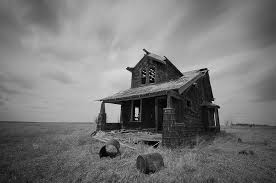

In [3]:
from PIL import Image
from colorization.colorizers import load_img, preprocess_img, postprocess_tens

img_path = '/Users/captain-mac/Downloads/images.jpg'

colorizer_coreml = ct.models.MLModel('ECCV16Colorize.mlpackage')

Image.open(img_path)

#### As per steps in the original `eecv16` model, preprocessing of the input image:
- convert to numpy array
- resizing to (512,512)

In [4]:
img = load_img(img_path)
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(512,512))

(tens_l_orig, tens_l_rs)

tens_ab_rs = colorizer_coreml.predict({'input1': tens_l_rs.numpy()})

tens_ab_rs['var_336'] # <- this is due to tens_ab_rs being a dict

array([[[[ 0.19299316,  0.19299316,  0.2854004 , ...,  6.0117188 ,
           5.9179688 ,  5.9179688 ],
         [ 0.19299316,  0.19470215,  0.2854004 , ...,  6.015625  ,
           5.921875  ,  5.9179688 ],
         [ 0.21313477,  0.21313477,  0.3022461 , ...,  5.9882812 ,
           5.9023438 ,  5.9023438 ],
         ...,
         [ 7.2695312 ,  7.2695312 ,  7.4648438 , ..., -8.234375  ,
          -8.1640625 , -8.1640625 ],
         [ 7.2773438 ,  7.2773438 ,  7.4609375 , ..., -7.96875   ,
          -7.8632812 , -7.8632812 ],
         [ 7.2773438 ,  7.2773438 ,  7.4609375 , ..., -7.96875   ,
          -7.8632812 , -7.8632812 ]],

        [[15.9765625 , 15.9765625 , 15.921875  , ..., -3.4316406 ,
          -3.2714844 , -3.2734375 ],
         [15.9765625 , 15.9765625 , 15.921875  , ..., -3.4316406 ,
          -3.2714844 , -3.2714844 ],
         [15.6171875 , 15.6171875 , 15.5390625 , ..., -3.7363281 ,
          -3.6152344 , -3.6152344 ],
         ...,
         [-7.125     , -7.125     

#### As per steps in the original `eecv16` model, postprocessing of the output tensor

In [37]:
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_coreml = postprocess_tens(tens_l_orig, torch.from_numpy(tens_ab_rs['var_336']))

minN = 0
maxN = 0
tens = tens_ab_rs['var_336'].shape
for y in range(tens_l_orig.shape[2]):
    for x in range(tens_l_orig.shape[3]):
        val = tens_l_orig[0, 0, y, x]
        if val > maxN:
            maxN = val
        if val < minN:
            minN = val

(minN, maxN)

(0, tensor(93.7482))

### Displaying out image

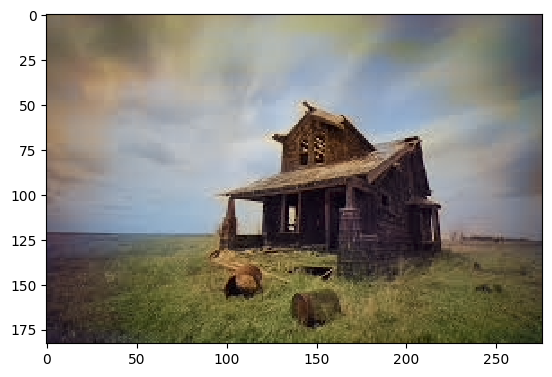

In [8]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(out_img_coreml, interpolation='nearest')
plt.show()